In [1]:
import xarray as xr
import geopandas as gpd
import fsspec
import numpy as np
from rasterio import features
from affine import Affine
import pandas as pd
import hvplot.pandas
import hydrotools as ht
import os
import matplotlib.pyplot as plt
import warnings
from distributed import Client, progress
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41601 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 67.47 GB


# Repertoires

In [3]:
# Repertoire contenant les shapefiles ou geojson
shp_files = 's3://watersheds-polygons/MELCC/json'

# Nom du bucket contenant les donnees ERA5-Land
bucket='s3://era5-atlantic-northeast/zarr/land/reanalysis'


# Configs

In [4]:
# Url du serveur contenant le bucket
client_kwargs={"endpoint_url":"https://s3.us-east-2.wasabisys.com"}

# Geopandas

In [5]:
epsg_ini = 4326
# Shapefiles/json to geopandas
gdf = ht.files_to_gdf(url=shp_files,
                      epsg=epsg_ini,
                      client_kwargs=client_kwargs)  
gdf

,Altitude,Descriptio,Etat,Inclus,Latitude,Longitude,Nom,OBJECTID,Proprietai,Regime,...,Shape_Area,Shape_Le_1,Shape_Leng,Station,Sup_Diffus,Sup_Km,Type,Type_stat,geometry,tp
0,50.3,"à 2,3 km en amont de la branche ouest",Fermé,oui,48.4777777778,-64.52861111110001,La Grande Rivière,1,MENV,Naturel,...,0.0652761069343,1.97437542906,169650.548302,ST_010101,NaN,530.602589599,NaN,Débit,"POLYGON ((-64.63738 48.69413, -64.63620 48.693...",010101
1,15.2,"à 9,7 km en amont du pont-route 132",Fermé,oui,48.1000238888,-65.4609027022,Bonaventure,2,MENV,Naturel,...,0.259261186252,3.50969600722,314860.080669,ST_010801,NaN,2112.20913932,NaN,Débit,"POLYGON ((-65.72905 48.91156, -65.72881 48.911...",010801
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,010802,1911,NaN,D,NaN,"POLYGON ((-65.74079 48.92132, -65.74000 48.921...",NaN
3,6.1,"à 3,9 km en amont du pont du C.N.",Fermé,oui,48.1905277778,-65.8113888889,Petite rivière Cascapédia,3,MENV,Naturel,...,0.172376406678,2.8303956776,255679.630187,ST_010901,NaN,1402.55385323,NaN,Débit,"POLYGON ((-65.78048 48.89303, -65.77983 48.892...",010901
4,27.4,"à 0,9 km rive gauche aval du pont route-couver...",Ouvert,oui,48.2321388889,-65.7330555556,Petite rivière Cascapédia,1,MENV,Naturel,...,0.163750210875,2.74484812698,247972.539999,ST_010902,NaN,1331.85452372,NaN,Débit,"POLYGON ((-65.78048 48.89303, -65.77983 48.892...",NaN
5,25,à 0.9 km rive droite aval pont-route couvert ...,Fermé,oui,48.232225,-65.73394999999999,Petite rivière Cascapédia,4,MENV,Naturel,...,0.16374664998,2.74467176046,247943.775209,ST_010903,NaN,1331.82533181,NaN,Débit,"POLYGON ((-65.78048 48.89303, -65.77983 48.892...",010903
6,147.8,"à 1,4 km en aval de la branche du lac",Fermé,oui,48.6664156416,-66.188701553,Cascapédia,5,MENV,Naturel,...,0.180294744943,2.55244209917,220749.462498,ST_011001,NaN,1461.48728416,NaN,Débit,"POLYGON ((-66.35506 48.95639, -66.35493 48.956...",011001
7,36.6,"à 1,3 km en amont de l'Angers",Fermé,oui,48.3178013298,-65.9717575662,Cascapédia,6,MENV,Naturel,...,0.292686667481,3.59970406747,314827.202446,ST_011002,NaN,2376.18438873,NaN,Débit,"POLYGON ((-66.35506 48.95639, -66.35493 48.956...",011002


# Xarray Dataset

In [6]:
# Mapping vers filesystem depuis le bucket
store = fsspec.get_mapper(url=bucket,
                          client_kwargs=client_kwargs,
                          anon=True)

# Ouverture du zarr vers dataset (xarray)
ds = xr.open_zarr(store,
                  consolidated=True,
                  chunks='auto')
ds

<xarray.Dataset>
Dimensions:    (latitude: 231, longitude: 441, time: 339648)
Coordinates:
  * latitude   (latitude) float32 63.0 62.9 62.8 62.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 -96.0 -95.9 -95.8 -95.7 ... -52.2 -52.1 -52.0
  * time       (time) datetime64[ns] 1981-01-01 ... 2019-09-30T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    licd       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sde        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    smlt       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    snowc      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-14 15:35:10 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

Pour plus d'informations sur les variables disponibles :

In [8]:
# ds.variables

Prenons par exemple la variable sd (snow depth water equivalent) :

In [7]:
ds.sd.data

,Array,Chunk
Bytes,138.40 GB,21.90 MB
Shape,"(339648, 231, 441)","(8760, 25, 25)"
Count,7021 Tasks,7020 Chunks
Type,float32,numpy.ndarray


# Application des moyennes bassins (xarray vers dataframe)

In [9]:
%%time

df = ht.clip_polygon_to_dataframe(dataset=ds,
                                  geodataframe=gdf, # prendre seulement les 3 premiers pour fin de tests
                                  geodf_index_column='Station',
                                  variable='sd',  
                                  aggregation='mean',
                                  resample_time='1D',
                                  from_tz='UTC',
                                  to_tz='America/Montreal',
                                  latlng_names=['latitude',
                                                'longitude']
                                  )
# Convertir vers le format de l'IC
# df.index = df.index.tz_convert(None).normalize() + pd.DateOffset(days=1)

ST_010101
ST_010801
010802
ST_010901
ST_010902
ST_010903
ST_011001
ST_011002
CPU times: user 3.66 s, sys: 379 ms, total: 4.04 s
Wall time: 15.1 s


# Dataframe

In [10]:
df

,ST_010101,ST_010801,010802,ST_010901,ST_010902,ST_010903,ST_011001,ST_011002
time,,,,,,,,
1980-12-31 00:00:00-05:00,0.200388,0.192549,0.200122,0.202556,0.202556,0.202556,0.201567,0.201023
1981-01-01 00:00:00-05:00,0.200418,0.192620,0.200211,0.202742,0.202742,0.202742,0.201931,0.201318
1981-01-02 00:00:00-05:00,0.200752,0.193014,0.200603,0.203094,0.203094,0.203094,0.202185,0.201621
1981-01-03 00:00:00-05:00,0.209094,0.200167,0.207721,0.210164,0.210164,0.210164,0.209507,0.208929
1981-01-04 00:00:00-05:00,0.210371,0.201214,0.208806,0.211300,0.211300,0.211300,0.210929,0.210260
...,...,...,...,...,...,...,...,...
2019-09-26 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-09-27 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-09-28 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Visualisation rapide

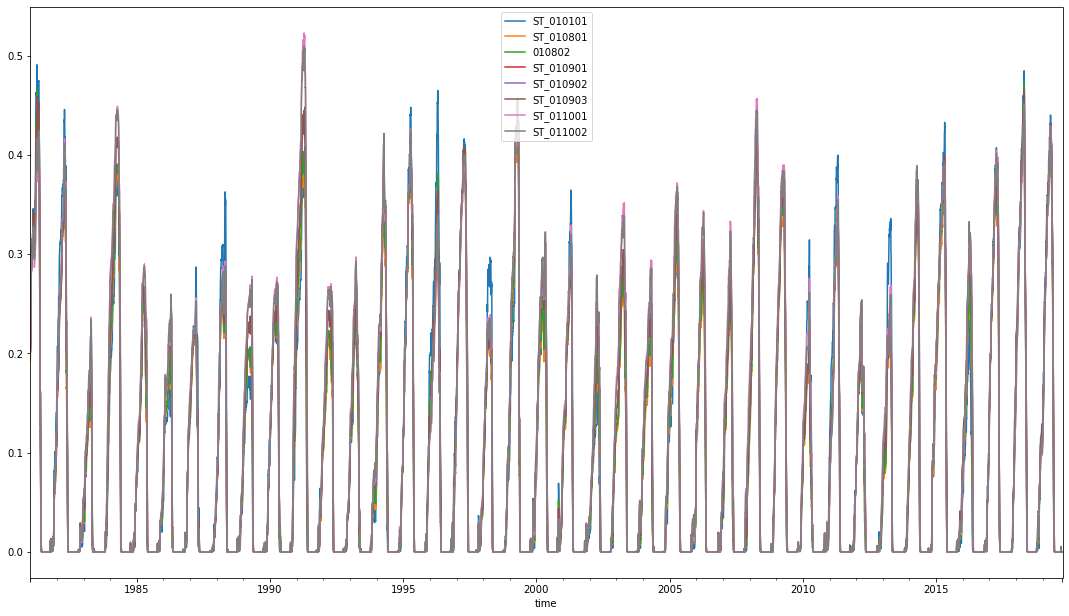

In [11]:
df.plot()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)